# Notebook para jugar con Crimson Red

Librerías

In [1]:
import chess
import numpy as np
import chess.pgn
from stockfish import Stockfish
import math
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import chess.engine
import random
import os

Para poder ejecutar de buena manera, debe escribir la ruta de la carpeta Proyecto-Crimson-Red

In [2]:
ruta_CR='C:/Users/Usuario/Desktop/Primavera_2023/Simulación/Proyecto/Proyecto-Crimson-Red/'

StockFish


In [3]:
StockFish_path=ruta_CR+'Stockfish/stockfish-windows-x86-64' #Ruta de stockfish (archivo .exe)
stockfish=Stockfish(StockFish_path)
stockfish.set_depth(10)#How deep the AI looks
stockfish.set_skill_level(20)#Highest rank stockfish
stockfish.set_elo_rating(3000)
stockfish.get_parameters()

{'Debug Log File': '',
 'Contempt': 0,
 'Min Split Depth': 0,
 'Ponder': 'false',
 'MultiPV': 1,
 'Skill Level': 20,
 'Move Overhead': 10,
 'Minimum Thinking Time': 20,
 'Slow Mover': 100,
 'UCI_Chess960': 'false',
 'UCI_LimitStrength': 'true',
 'UCI_Elo': 3000,
 'Threads': 1,
 'Hash': 16}

Funciones necesarias para utilizar el modelo

In [4]:
def make_matrix(board):
    '''
    Esta función retorna el tablero en formato de matriz donde las piezas son representadas por los
    strings ['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k' ].
    
    Mayúsculas es para blancas y minúsculas para negras
    
    '''
    
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return np.array(foo)
    
def piece_matrix(Board):
    '''
    Esta función retorna un tensor de (12, 8, 8), donde cada matriz de (8,8) representa las posiciones de un tipo de pieza
    de un color en el siguiente orden:
    
    [ [peones blancos], [caballos blancos], [alfiles blancos], [torres blancas], [reina blanca], [rey blanco],
    [peones negros], [caballos negros], [alfiles negros], [torres negas], [reina negra], [rey negro] ]
    '''
    
    M = make_matrix(Board)
    
    assert np.shape(M)==(8,8)
    
    piezas=['P', 'N', 'B', 'R', 'Q', 'K', 'p', 'n', 'b', 'r', 'q', 'k' ]

    A = []
    for p in piezas:

        
        Mp = np.zeros(np.shape(M))

        for i in range(8):
            for j in range(8):
                
                if M[i][j]==p:
                    Mp[i][j]=1
                        
        A.append(Mp)  

    return A    

            
def Globalfeatures(board):
    
    '''
    Esta función retorna un tensor de (5, 8, 8) que representa el turno y los 4 derechos de enroque posibles
    '''
    
    PM=piece_matrix(board)
    
    #Turno
    
    if board.turn:
        side_to_move = np.ones((8,8)) #Turno de blancas
    else:
        side_to_move = np.zeros((8,8)) #Turno de Negras
        
    #Derechos de Enroque
    
    if board.has_kingside_castling_rights(1): #blanco
        
        crw1=np.ones((8,8))
        
    else:
        
        crw1=np.zeros((8,8))
        
    if board.has_queenside_castling_rights(1): #blanco
        
        crw2=np.ones((8,8))
        
    else:
        
        crw2=np.zeros((8,8)) 
        
        
    if board.has_kingside_castling_rights(0): #negro
        
        
        crb1=np.ones((8,8))
        
    else:
        
        crb1=np.zeros((8,8))        
        
        
    if board.has_queenside_castling_rights(0):  #negro
        
        crb2=np.ones((8,8))
        
    else:
        
        crb2=np.zeros((8,8))        
    
    
     
    
    return [side_to_move, crw1, crw2, crb1, crb2]



def board2vec(Board):
    '''
    Esta función retorna el tensor de (17, 8, 8) de representación del tablero
    '''
    
    PM = np.array(piece_matrix(Board))
    GF = np.array(Globalfeatures(Board))
    
    return np.concatenate((PM,GF))
        

In [5]:
def sf_eval_s(board):
    
    '''
    Esta función retorna la evaluación de StockFish de una posición.
    '''
    
    
    stockfish.set_fen_position(board.fen())
    e_dict = stockfish.get_evaluation()
    if e_dict['type']=='cp':
        return e_dict['value']
    
    elif e_dict['type']=='mate' and e_dict['value']==0:
            
        if board.outcome().winner:
            
            return 15000
        
        else:
            return -15000
        
    else:
        
        assert e_dict['type']=='mate'
        
        if e_dict['value']<=0:
            return -15000
        
        else:
            return 15000
    
    

Cargamos el modelo

In [6]:
model_path=ruta_CR+"Crimson_Red_v10_50e.h5"
model=tf.keras.models.load_model(model_path, compile=False)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17, 8, 8)]        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 8, 128)        9344      
                                                                 
 batch_normalization_6 (Batc  (None, 17, 8, 128)       512       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 17, 8, 128)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 8, 128)        147584    
                                                                 
 batch_normalization_7 (Batc  (None, 17, 8, 128)       512       
 hNormalization)                                           

Creamos Una funcion para Utilizar el modelo con alpha-beta prunning

In [7]:
def minimax_eval(board):
    
    a=np.array([board2vec(board)])
    pred=model.predict(a)

    return pred[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minimax_eval(board)
  
    if maximizing_player:
        max_eval = -np.inf
        for move in sorted(board.legal_moves, key=lambda move: board.is_capture(move), reverse=True): 
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = np.inf
        for move in sorted(board.legal_moves, key=lambda move: board.is_capture(move), reverse=True):
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
        return min_eval



def get_ai_move_black(board, depth):
    best_move = None
    min_eval = np.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -np.inf, np.inf, True)
        board.pop()
        if eval < min_eval:
            min_eval = eval
            best_move = move
  
    return best_move


def get_ai_move_white(board, depth):
    best_move = None
    max_eval = -np.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -np.inf, np.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            best_move = move
  
    return best_move

Creamos una función para jugar contra el modelo en función de la profundidad. 

In [8]:
def play_white(depth):
    board = chess.Board()
    display(board)
    while not board.is_game_over():
        move=input('Su turno, elija una jugada')
        board.push_san(move)
        display(board)
        print('Evaluacion Modelo: ',minimax_eval(board))
        stockfish.set_fen_position(board.fen())
        print('Evaluacion StockFish: ',stockfish.get_evaluation())
        
        if board.is_game_over():
            print('Has ganado!')
            
            return
            
        else:
            aimove=get_ai_move_black(board, depth)

            board.push(aimove)
            display(board)
            print('Evaluacion Modelo',minimax_eval(board))
            stockfish.set_fen_position(board.fen())
            print('Evaluacion StockFish: ',stockfish.get_evaluation())
            
    print('Has perdido!')
    return

In [11]:
def play_black(depth):
    board = chess.Board()
    display(board)
    while not board.is_game_over():
    
        aimove=get_ai_move_white(board, depth)
        board.push(aimove)
        display(board)
        print('Evaluacion Modelo',minimax_eval(board))
        stockfish.set_fen_position(board.fen())
        print('Evaluacion StockFish: ',stockfish.get_evaluation())
        
        if board.is_game_over():

            if board.outcome().winner:
                
                print('Has perdido!')
                
                return 
            
            if board.outcome().winner== None:
                
                print('Empate!')
                
                return 
        
        else:
            move=input('Su turno, elija una jugada')
            board.push_san(move)
            display(board)
            print('Evaluacion Modelo: ',minimax_eval(board))
            stockfish.set_fen_position(board.fen())
            print('Evaluacion StockFish: ',stockfish.get_evaluation())
        
  
            
    if not board.outcome().winner:
        
        print('Has Ganado!')
        
        return 

    if board.outcome().winner== None:

        print('Empate!')
        
        return 0        


In [ ]:
#Jugar con el modelo
play_white(1)

Creamos una función para que nuestro modelo juege con StockFish

In [25]:
def engine_black_vs_stockfish(CR_depth, SF_elo, show=False):
    
    '''
    CR_depth es la profundidad con la que juega el modelo.
    SF_elo es el elo con que juega StockFish. El mínimo es 1320
    Retorna una tupla (G,J), donde G=1 si ganaron las blancas, G=-1 sin ganaron las negras, G=0 si hubo tablas
    y J es la cantidad de jugadas que hubo en la partida
    '''
    
    engine = chess.engine.SimpleEngine.popen_uci(StockFish_path)
    engine.configure({"UCI_LimitStrength": True, "UCI_Elo": SF_elo})
    
    Jugadas=0
    board = chess.Board()
    if show:
        display(board)
    while not board.is_game_over():

        
        result = engine.play(board, chess.engine.Limit(time=0.1))
        move=result.move
        board.push(move)
        if show:
            display(board)
        Jugadas+=1
        
        if board.is_game_over():
            
            if board.outcome().winner:
                
                return 1 , Jugadas
            
            if board.outcome().winner== None:
                
                return 0 , Jugadas
        else:
            aimove=get_ai_move_black(board, CR_depth)
            board.push(aimove)
            if show:
                display(board)
            Jugadas+=1
    

    if board.outcome().winner== None:

        return 0, Jugadas

    else:
            
        return -1, Jugadas
    
def engine_white_vs_stockfish(CR_depth, SF_elo, show=False):
    
    '''
    CR_depth es la profundidad con la que juega el modelo.
    SF_elo es el elo con que juega StockFish. El mínimo es 1320
    Retorna una tupla (G,J), donde G=1 si ganaron las blancas, G=-1 sin ganaron las negras, G=0 si hubo tablas
    y J es la cantidad de jugadas que hubo en la partida
    '''
    
    engine = chess.engine.SimpleEngine.popen_uci(StockFish_path)
    engine.configure({"UCI_LimitStrength": True, "UCI_Elo": SF_elo})
    
    Jugadas=0
    board = chess.Board()
    if show:
        display(board)
    while not board.is_game_over():
        
        aimove=get_ai_move_white(board, CR_depth)
        board.push(aimove)
        if show:
            display(board)
        Jugadas+=1
        
        
        if board.is_game_over():
            
            if board.outcome().winner:
                
                return 1, Jugadas
            
            if board.outcome().winner== None:
                
                return 0, Jugadas
        else:
            result = engine.play(board, chess.engine.Limit(time=0.1))
            move=result.move
            board.push(move)
            if show:
                display(board)
            Jugadas+=1

    if board.outcome().winner== None:

        return 0, Jugadas
    
    
    else:
        
        return -1, Jugadas
    

In [13]:
engine_white_vs_stockfish(1, 1320)

(-1, 46)

In [26]:
engine_black_vs_stockfish(1, 1320)

(1, 87)

Creamos una función para que se juegen múltiples partidas contra stockfish

In [14]:
def test_model_elo(n, color, CR_depth, SF_elo):
    
    
    if color == 'w':
        P=[]
        
        J=[]
        
        for i in range(n):
            r, j = engine_white_vs_stockfish(CR_depth, SF_elo)
            P.append(r)
            J.append(j)
            
        P=np.array(P)
        
        w = (P==1).sum()
        b = (P==-1).sum()
        d = (P==0).sum()
        
        print('Crimson Red Jugó con blancas')
        print('StockFish Jugó con negras')
        print('Elo de StockFish: ', SF_elo)
        print('Número de partidas Jugadas: ', n)
        print('Partidas ganadas por Crimson Red: ', w )
        print('Partidas ganadas por StockFish: ', b)
        print('Partidas empatadas: ', d)
        print('Número promedio de jugadas por partida: ', sum(J)/n)
        print('Mayor número de jugadas: ', max(J))
        print('Menor número de jugadas: ', min(J))
        
            
        
    elif color=='b':    
        
        P=[]
        
        J=[]
        
        for i in range(n):
            r, j = engine_black_vs_stockfish(CR_depth, SF_elo)
            P.append(r)
            J.append(j)
            
        P=np.array(P)
        
        w = (P==1).sum()
        b = (P==-1).sum()
        d = (P==0).sum()  
        
        print('Crimson Red Jugó con negras')
        print('StockFish Jugó con blancas')
        print('Elo de StockFish: ', SF_elo)
        print('Número de partidas Jugadas: ', n)
        print('Partidas ganadas por Crimson Red: ', b )
        print('Partidas ganadas por StockFish: ', w)
        print('Partidas empatadas: ', d)
        print('Número promedio de jugadas por partida: ', sum(J)/n)
        print('Mayor número de jugadas: ', max(J))
        print('Menor número de jugadas: ', min(J))
    

In [14]:
test_model_elo(25, 'w', 1, 1320)

Crimson Red Jugó con blancas
StockFish Jugó con negras
Elo de StockFish:  1320
Número de partidas Jugadas:  25
Partidas ganadas por Crimson Red:  0
Partidas ganadas por StockFish:  25
Partidas empatadas:  0
Número promedio de jugadas por partida:  37.12
Mayor número de jugadas:  56
Menor número de jugadas:  20


In [14]:
test_model_elo(25, 'b', 1, 1320)

Crimson Red Jugó con negras
StockFish Jugó con blancas
Elo de StockFish:  1320
Número de partidas Jugadas:  25
Partidas ganadas por Crimson Red:  0
Partidas ganadas por StockFish:  25
Partidas empatadas:  0
Número promedio de jugadas por partida:  37.4
Mayor número de jugadas:  65
Menor número de jugadas:  15


Cresmos una función para que el modelo juege contra stockfish y se guarde la partida en un archivo pgn

In [27]:
def engine_white_vs_stockfish_pgn(depth, elo, pgn_filename, show=False):
    
    '''
    CR_depth es la profundidad con la que juega el modelo.
    SF_elo es el elo con que juega StockFish. El mínimo es 1320
    pgn_filename es la ruta donde se guarda el pgn.
    Si show=True, se muestra el tablero luego de cada juegada
    
    Retorna una tupla (G,J), donde G=1 si ganaron las blancas, G=-1 sin ganaron las negras, G=0 si hubo tablas
    y J es la cantidad de jugadas que hubo en la partida
    '''
    
    engine = chess.engine.SimpleEngine.popen_uci(StockFish_path)
    engine.configure({"UCI_LimitStrength": True, "UCI_Elo": elo})
    
    Jugadas=0
    board = chess.Board()
    
    game = chess.pgn.Game()
    node = game
    
    if show:
        display(board)
    while not board.is_game_over():
        
        aimove=get_ai_move_white(board, depth)
        board.push(aimove)
        node = node.add_variation(aimove)
        
        if show:
            display(board)
        Jugadas+=1
        
        
        if board.is_game_over():
            #display(board)
            if board.outcome().winner:
                
                with open(pgn_filename, "w") as pgn_file:
                    mainline_game = game.root().game()
                    mainline_game.headers.clear()  
                    exporter = chess.pgn.FileExporter(pgn_file)
                    mainline_game.accept(exporter)

                
                
                return 1, Jugadas
            
            if board.outcome().winner== None:
                
                
                with open(pgn_filename, "w") as pgn_file:
                    mainline_game = game.root().game()
                    mainline_game.headers.clear()  
                    exporter = chess.pgn.FileExporter(pgn_file)
                    mainline_game.accept(exporter)

                
                return 0, Jugadas
        else:
            result = engine.play(board, chess.engine.Limit(time=0.1))
            move=result.move
            board.push(move)
            node = node.add_variation(move)
            if show:
                display(board)
            Jugadas+=1


    if board.outcome().winner== None:
        
        with open(pgn_filename, "w") as pgn_file:
            mainline_game = game.root().game()
            mainline_game.headers.clear()  
            exporter = chess.pgn.FileExporter(pgn_file)
            mainline_game.accept(exporter)


        return 0, Jugadas
    
    else:
        
        assert not board.outcome().winner
        
        
        with open(pgn_filename, "w") as pgn_file:
            mainline_game = game.root().game()
            mainline_game.headers.clear() 
            exporter = chess.pgn.FileExporter(pgn_file)
            mainline_game.accept(exporter)


        return -1, Jugadas
    
    

    
    
def engine_black_vs_stockfish_pgn(depth, elo, pgn_filename, show=False):
    
    '''
    CR_depth es la profundidad con la que juega el modelo.
    SF_elo es el elo con que juega StockFish. El mínimo es 1320
    pgn_filename es la ruta donde se guarda el pgn.
    Si show=True, se muestra el tablero luego de cada juegada
    
    Retorna una tupla (G,J), donde G=1 si ganaron las blancas, G=-1 sin ganaron las negras, G=0 si hubo tablas
    y J es la cantidad de jugadas que hubo en la partida
    '''
    
    engine = chess.engine.SimpleEngine.popen_uci(StockFish_path)
    engine.configure({"UCI_LimitStrength": True, "UCI_Elo": elo})
    
    Jugadas=0
    board = chess.Board()
    
    game = chess.pgn.Game()
    node = game
    
    if show:
        display(board)
    while not board.is_game_over():
        
        result = engine.play(board, chess.engine.Limit(time=0.1))
        move=result.move
        board.push(move)
        node = node.add_variation(move)
        
        if show:
            display(board)
        Jugadas+=1
        
        
        if board.is_game_over():
            
            if board.outcome().winner:
                
                with open(pgn_filename, "w") as pgn_file:
                    mainline_game = game.root().game()
                    mainline_game.headers.clear()  
                    exporter = chess.pgn.FileExporter(pgn_file)
                    mainline_game.accept(exporter)

                
                
                return 1, Jugadas
            
            if board.outcome().winner== None:
                
                
                with open(pgn_filename, "w") as pgn_file:
                    mainline_game = game.root().game()
                    mainline_game.headers.clear()  
                    exporter = chess.pgn.FileExporter(pgn_file)
                    mainline_game.accept(exporter)

                
                return 0, Jugadas
        else:
            
            
            aimove=get_ai_move_black(board, depth)
            board.push(aimove)
            node = node.add_variation(aimove)
        
            if show:
                display(board)
            Jugadas+=1


    if board.outcome().winner== None:
        
        with open(pgn_filename, "w") as pgn_file:
            mainline_game = game.root().game()
            mainline_game.headers.clear()  
            exporter = chess.pgn.FileExporter(pgn_file)
            mainline_game.accept(exporter)


        return 0, Jugadas
    
    else:
        
        assert not board.outcome().winner
        
        
        with open(pgn_filename, "w") as pgn_file:
            mainline_game = game.root().game()
            mainline_game.headers.clear() 
            exporter = chess.pgn.FileExporter(pgn_file)
            mainline_game.accept(exporter)


        return -1, Jugadas
    
    
        

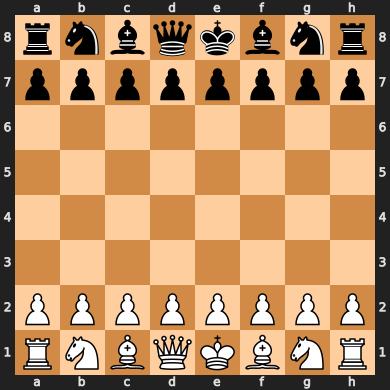

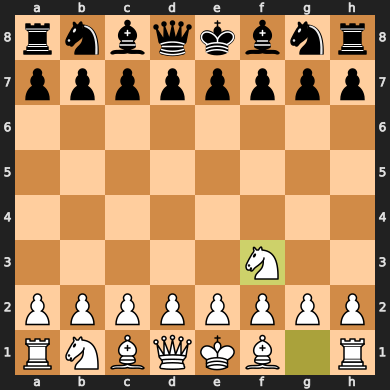

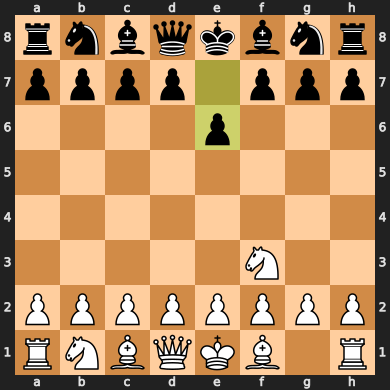

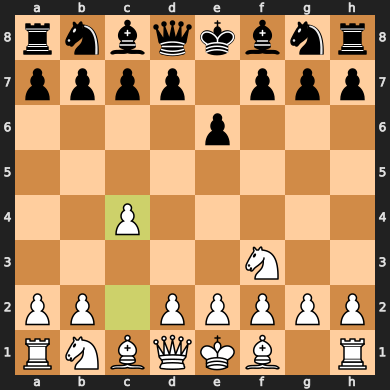

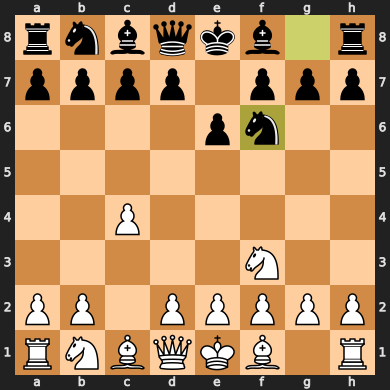

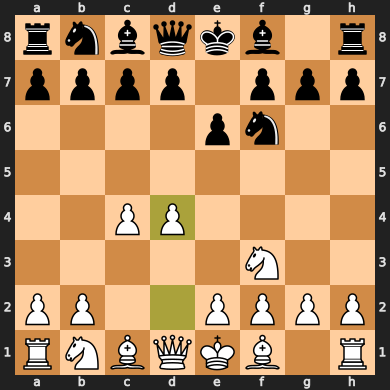

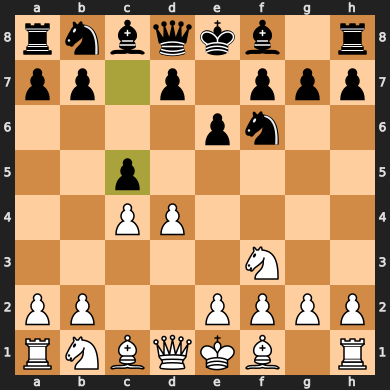

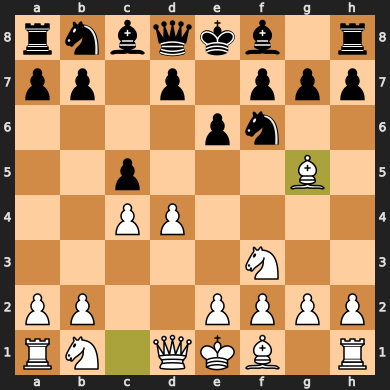

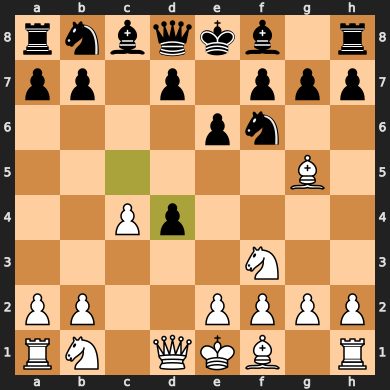

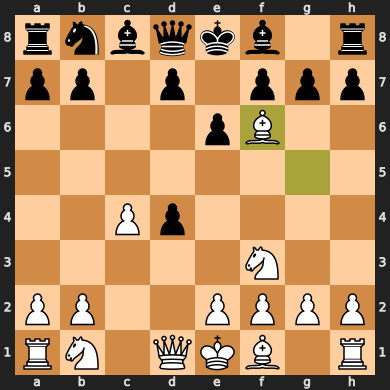

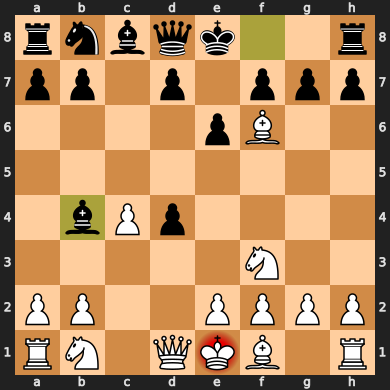

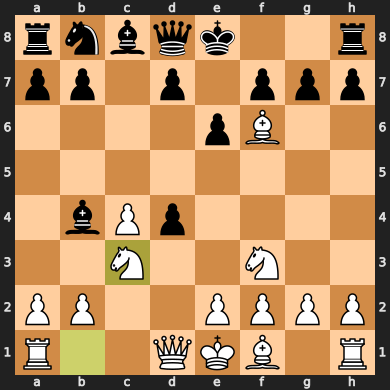

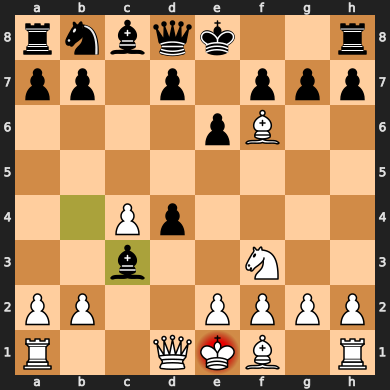

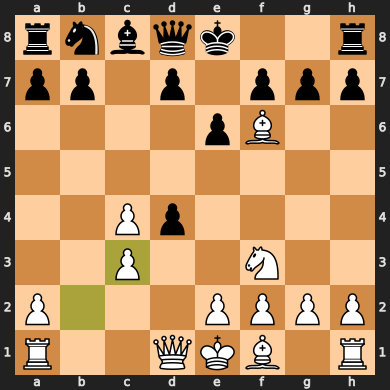

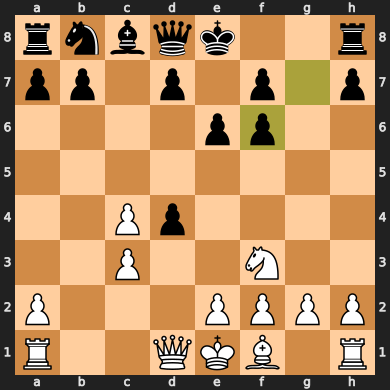

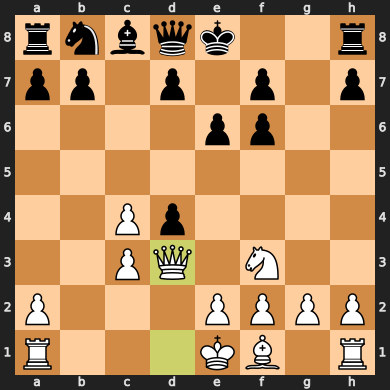

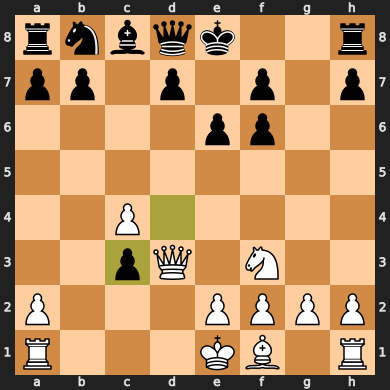

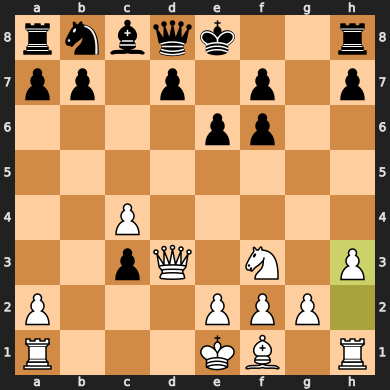

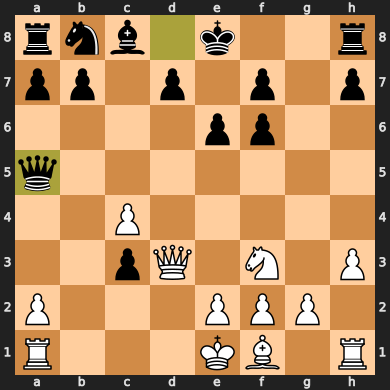

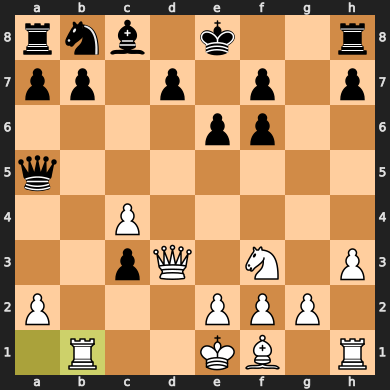

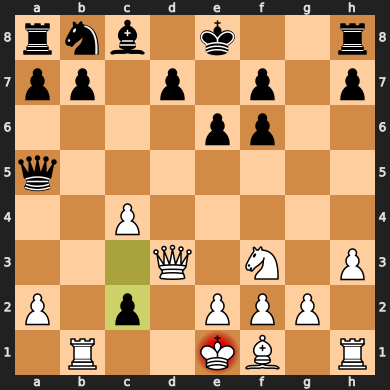

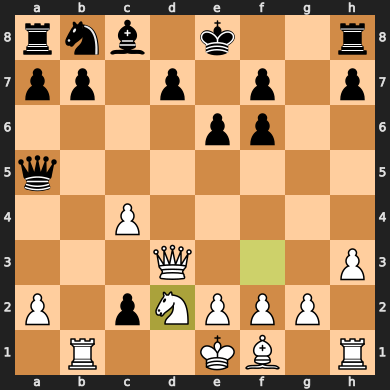

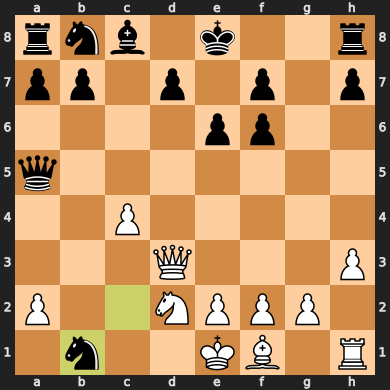

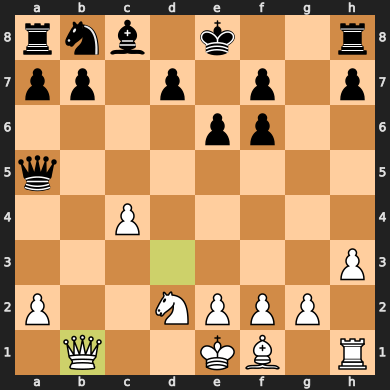

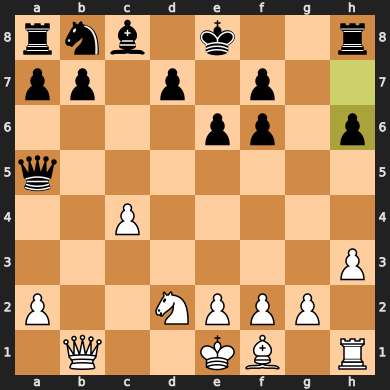

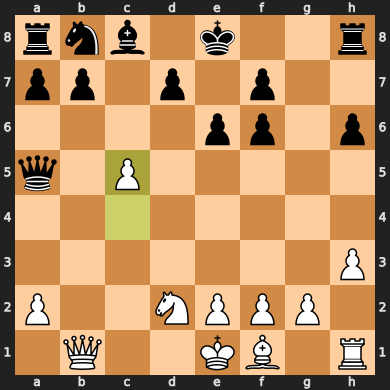

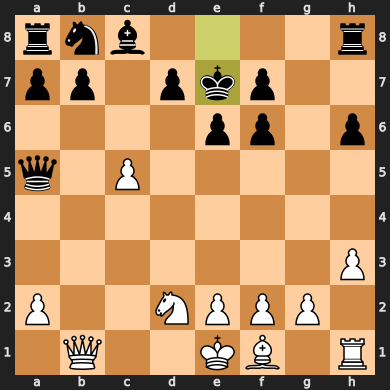

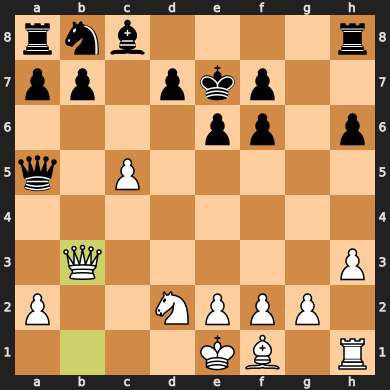

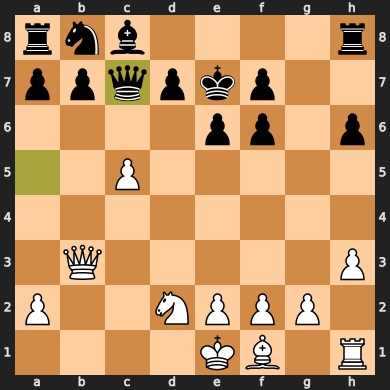

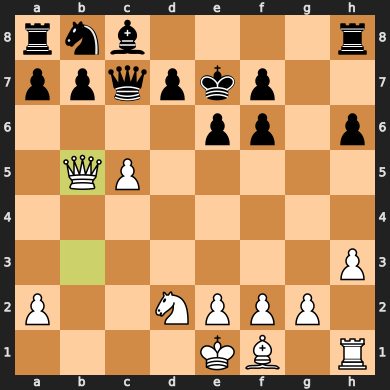

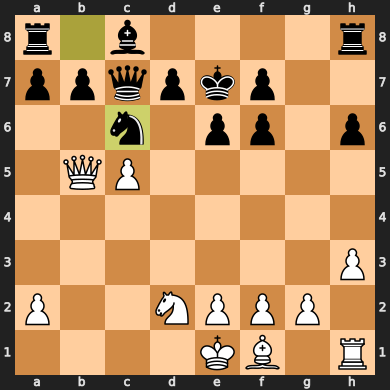

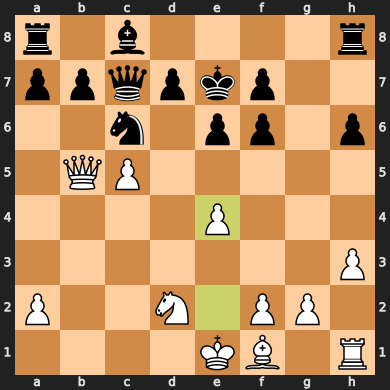

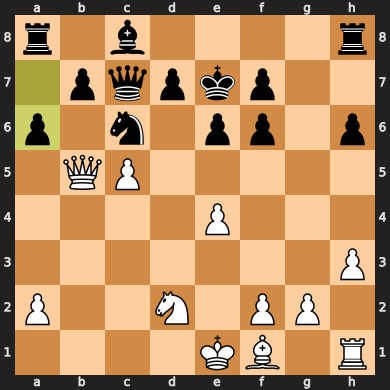

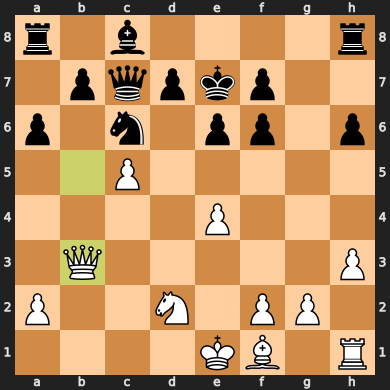

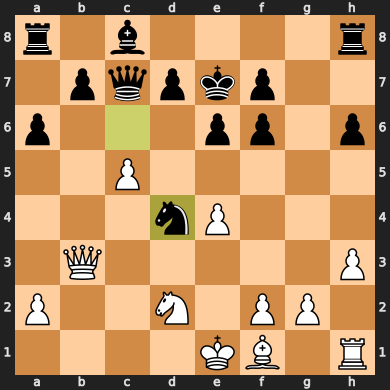

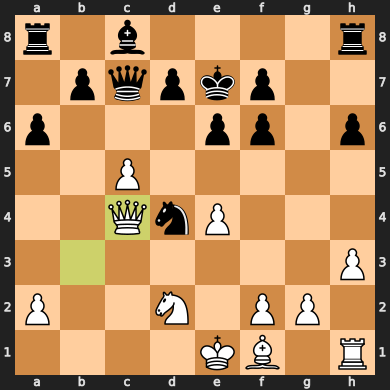

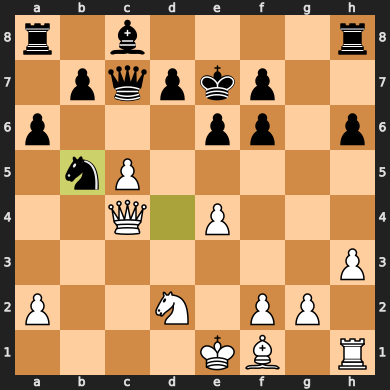

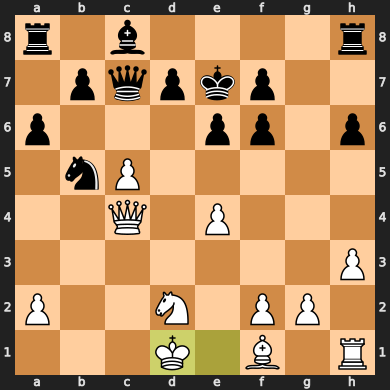

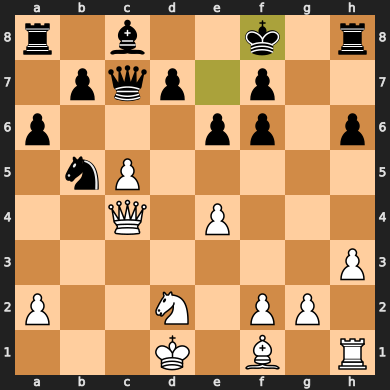

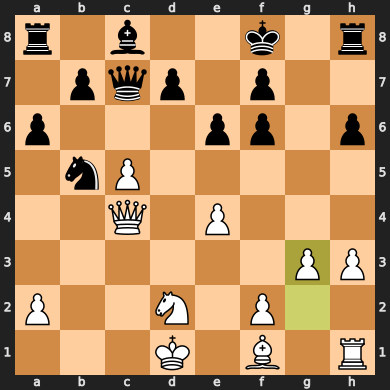

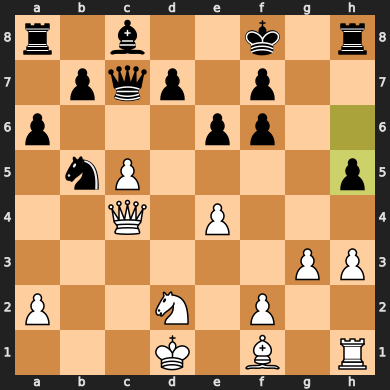

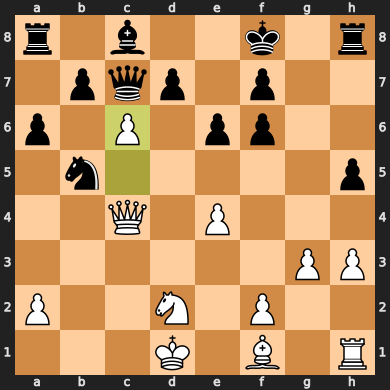

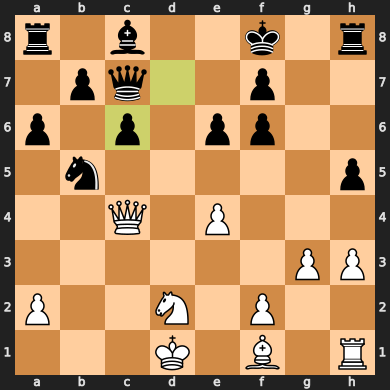

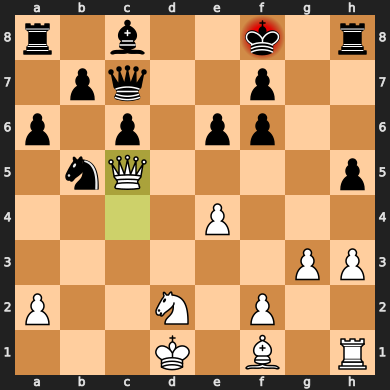

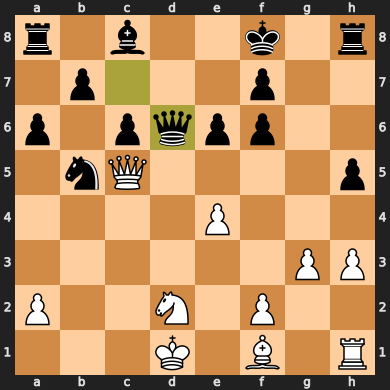

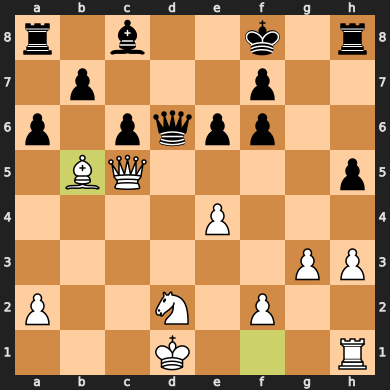

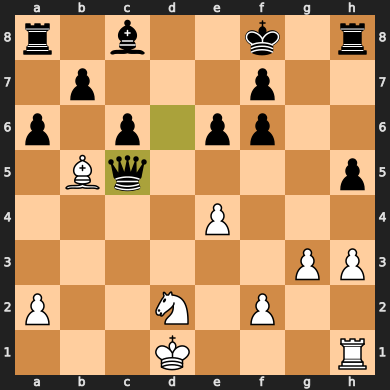

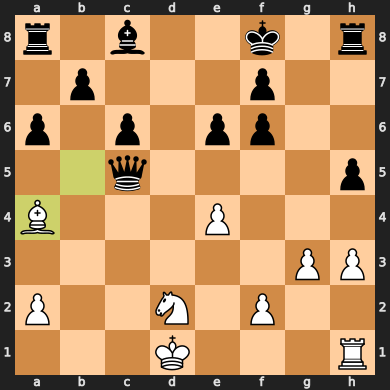

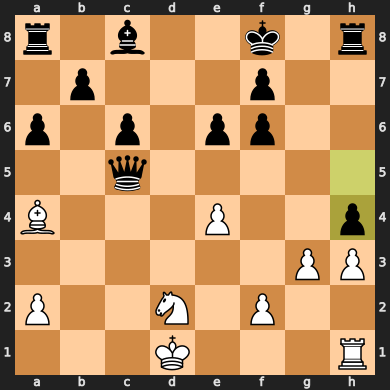

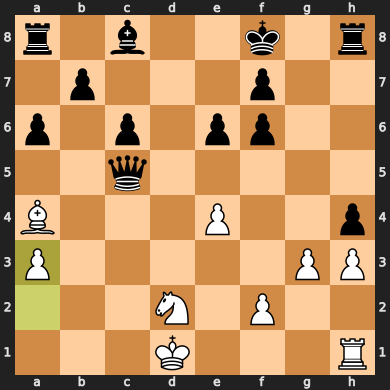

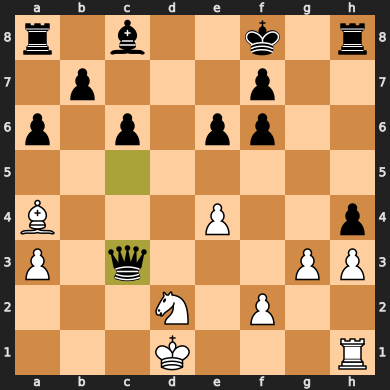

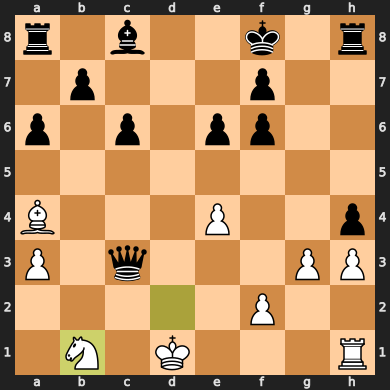

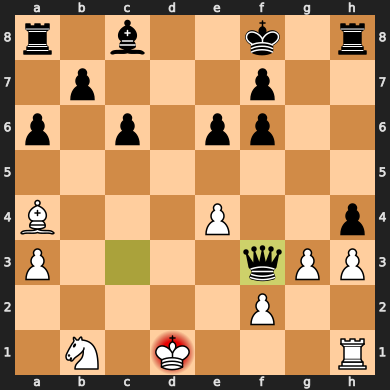

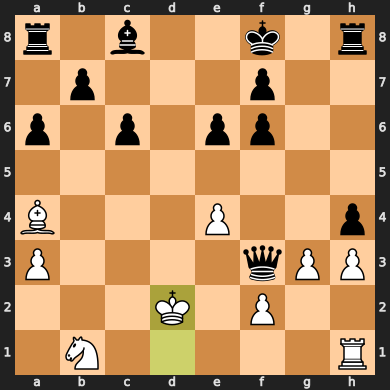

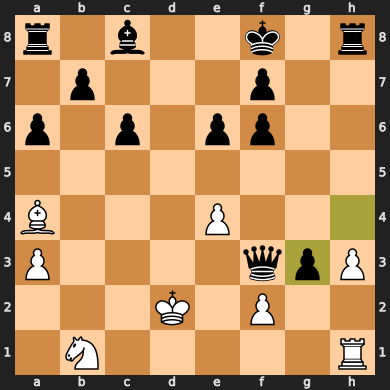

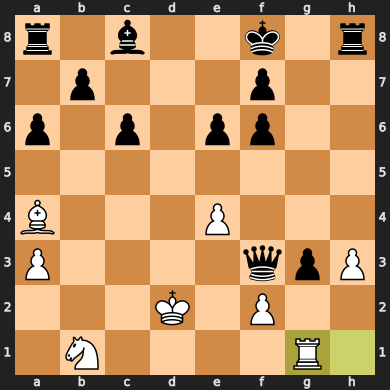

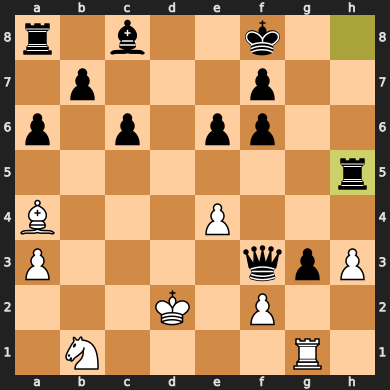

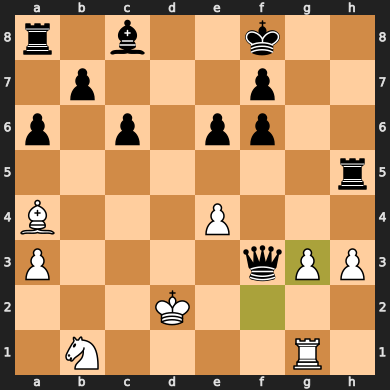

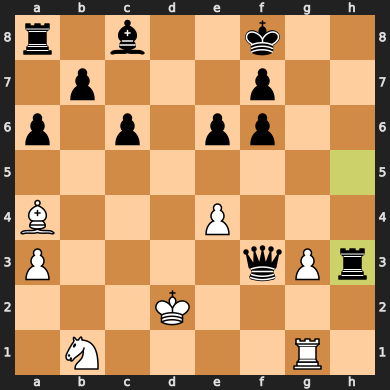

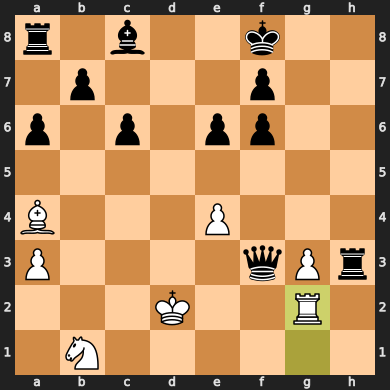

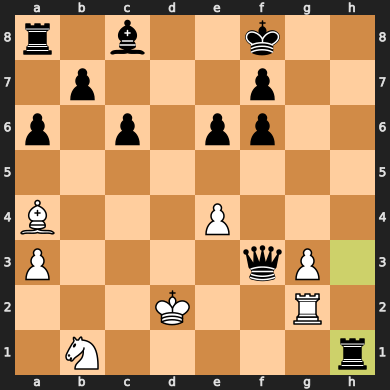

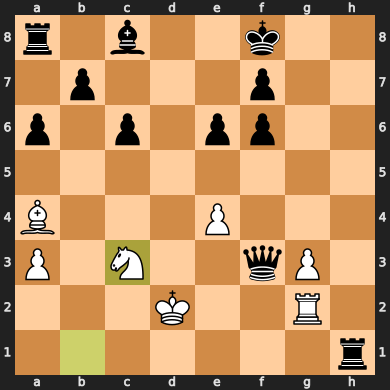

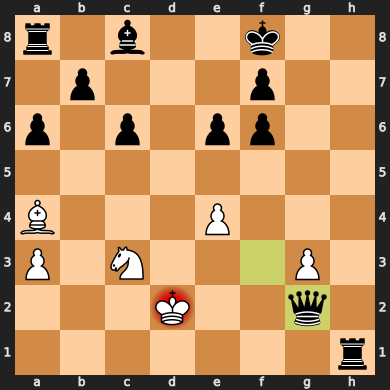

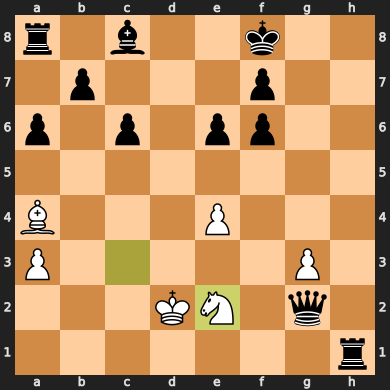

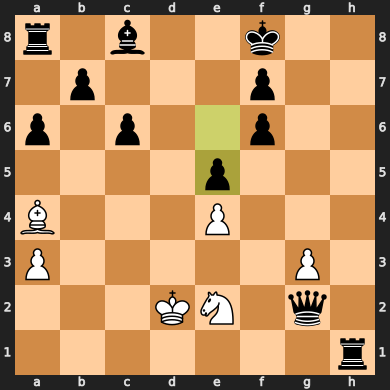

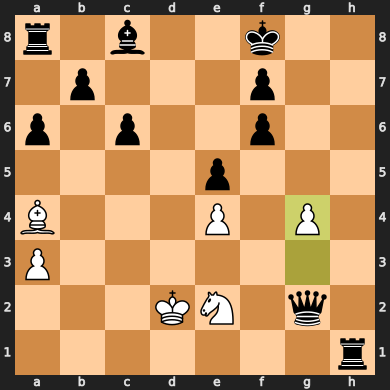

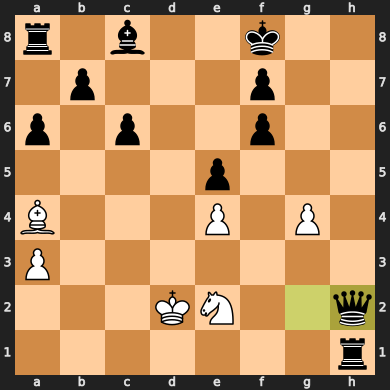

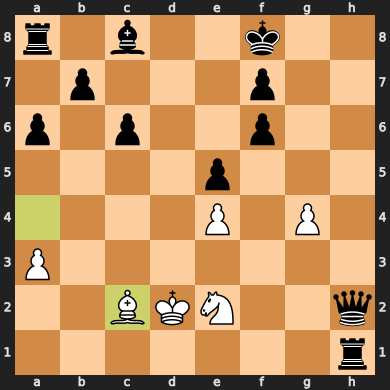

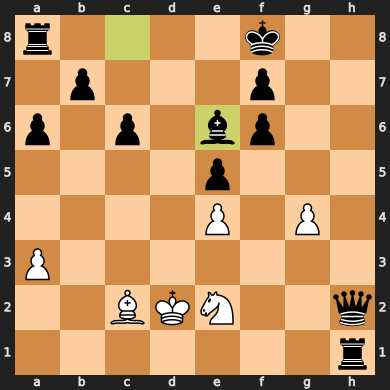

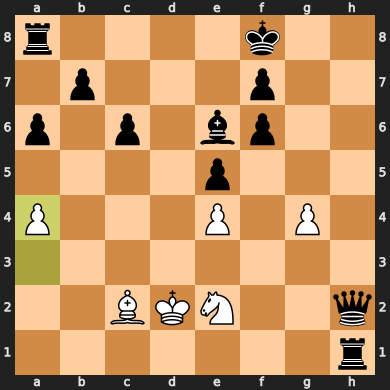

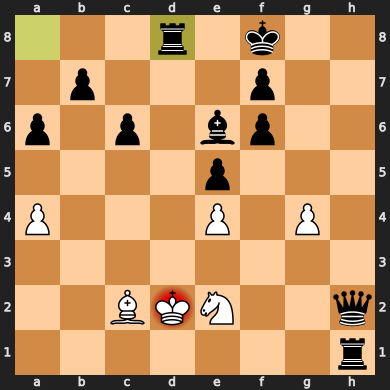

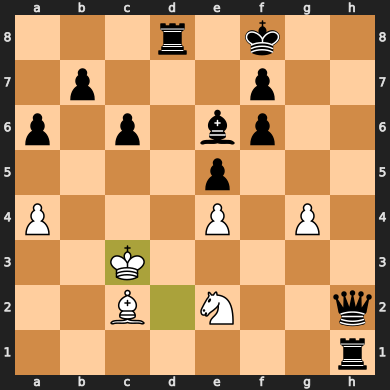

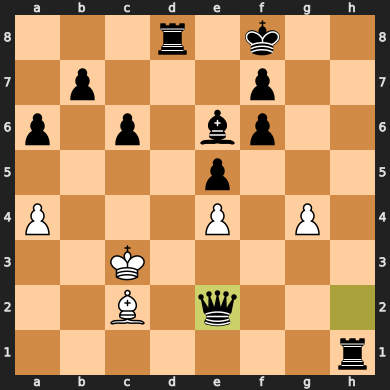

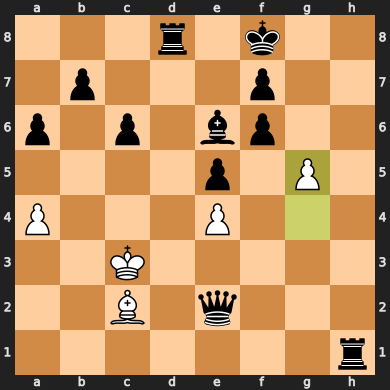

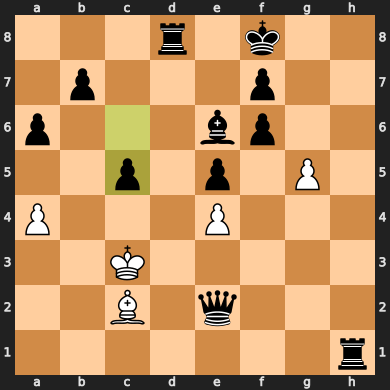

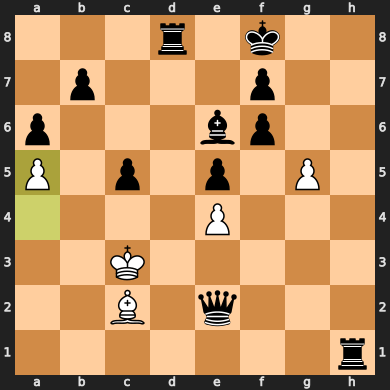

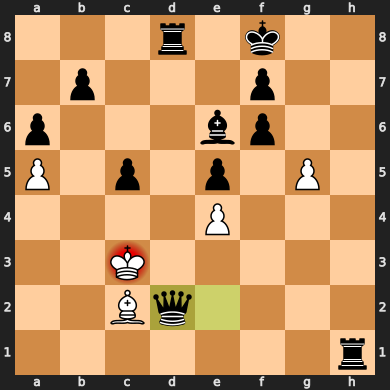

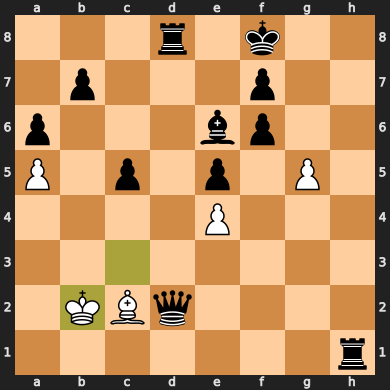

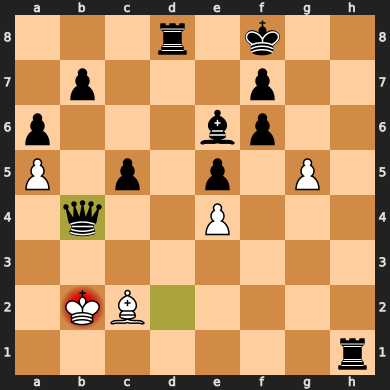

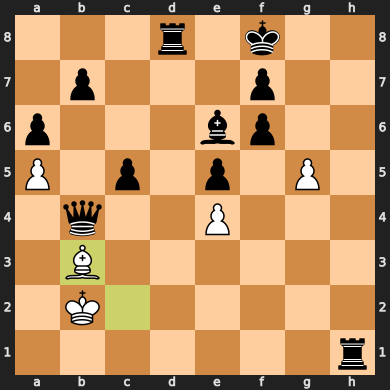

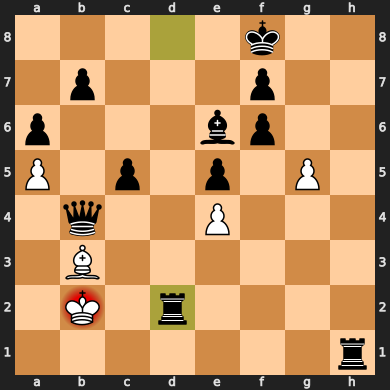

(-1, 80)

In [20]:
pgn_filename=ruta_CR+'Partidas_Crimson_red/Crimson_Red_v10_50e_depth_3_white_10.pgn'
depth=3
elo=1320
engine_white_vs_stockfish_pgn(depth, elo, pgn_filename, True)